# Reacher

Here is my solution to project 2: countinuous control of the Udacity Deep Reinforcement Learning Nanodegree.

For my solution I used a (Deep Deterministic Policy Gradient algorithm)[https://arxiv.org/pdf/1509.02971.pdf]. My solution is very close to the reference implementation form the paper.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

Loading the environment. To use please replace the value of the file_name with the location of the reacher environment.

In [2]:
env = UnityEnvironment(file_name='reacher/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Agent and Neural Network architecture
Here is the initialization of the ddpg agent and all the hyper parameters used (minus the model's layer unit sizes which I have defined in model.py)

For the most part I used hyperparameters that match the examples we viewed in class. I struggled to get good result initially, I tried various options finaly increasing the tau value seemed to help. I presume that the model was getting stuck and making it update it's target weights more frequently helped keep it learning. 

I also increased the value of the batch size which seemed to help by making the agent accumulate more experiences before the actor and critic start to learn. 

The model for the actor has three fully connected layers with a rectified linear unit (ReLU) activation function on the first two layers and uses tanh after the third layer. First two layers are 400, 300 units in size. 

The critic network uses 4 fully connected layers. Interestingly the critic model from the class examples used LeakyReLU instead of regular ReLU. I'm not sure why and could find anything online to explain the advantage for the critic to use it. I may have missed it in class but I don't think it was covered. The first three layers are 512, 256 and 128 units in size. 

Noise was added using an Ornstein-Uhlenbeck process (as recommended in the paper) theta and sigma were set as the same values as the paper 0.15 and 0.2 respectively. 

In [5]:
agent = Agent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=int(1e5),  
    batch_size=256,    
    gamma=0.99,           
    tau=1e-1,
    lr_actor=1e-3,       
    lr_critic=3e-4,        
    weight_decay=1e-3,
    random_seed=0
)


Episode 100	Average Score: 4.05
Episode 200	Average Score: 14.68
Episode 300	Average Score: 25.14
Episode 357	Average Score: 30.12
Environment solved in 257 episodes!	Average Score: 30.12


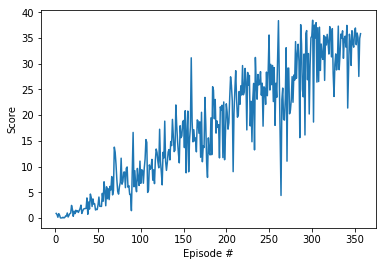

In [6]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()

## Future Improvements

I've seen suggestions that others have had success with similar problems using using a Proximal Policy Optimization algorithm instead ddpg. 

I'd also like to see the difference between DDPG and D4PG by implementing Option 2 of the project. Unfortunately due to time I didn't get to try it yet. 
